In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import splitfolders

In [58]:
splitfolders.ratio('./dogs vs wolves', output='./wolves vs dogs', seed=1337, ratio=(.7, .2, .1))

Copying files: 2000 files [00:02, 835.69 files/s]


In [59]:
# 1. 경로 설정 및 데이터 전처리
base_dir_similar = './wolves vs dogs'
base_dir_dissimilar = './fox'

In [60]:
# 이미지 증강 및 정규화
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [61]:
# 도메인 유사: Dogs vs Wolves

train_gen_similar = train_datagen.flow_from_directory(
    os.path.join(base_dir_similar, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_gen_similar = val_test_datagen.flow_from_directory(
    os.path.join(base_dir_similar, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_gen_similar = val_test_datagen.flow_from_directory(
    os.path.join(base_dir_similar, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [62]:
# 도메인 상이: Fox Dataset
train_gen_dissimilar = train_datagen.flow_from_directory(
    os.path.join(base_dir_dissimilar, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_gen_dissimilar = val_test_datagen.flow_from_directory(
    os.path.join(base_dir_dissimilar, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_gen_dissimilar = val_test_datagen.flow_from_directory(
    os.path.join(base_dir_dissimilar, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 243 images belonging to 1 classes.
Found 29 images belonging to 1 classes.
Found 77 images belonging to 1 classes.


In [63]:
# 2. 모델 구성 함수 정의
def build_vgg16_model(fine_tune=False):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Feature extractor로 사용
    if not fine_tune:
        base_model.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-4:]:  # block5_conv 레이어 일부만 fine-tune
            layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

In [64]:
# 3. 학습 함수 정의
def train_model(model, train_data, val_data, save_name):
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(save_name, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]

    history = model.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks=callbacks
    )
    return model, history


In [65]:
# 4. 평가 함수
def evaluate_model(model, test_data):
    y_true = test_data.classes
    y_pred = model.predict(test_data)
    y_pred_label = (y_pred > 0.5).astype(int)

    print("Classification Report:\n", classification_report(y_true, y_pred_label))

    cm = confusion_matrix(y_true, y_pred_label)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices,
                yticklabels=test_data.class_indices)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


===== Case 1: Dogs vs Wolves (도메인 유사) =====

Epoch 1/30


c:\ProgramData\anaconda3\envs\dsgs\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.4905 - loss: 0.7406 - val_accuracy: 0.7350 - val_loss: 0.6412 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.5464 - loss: 0.6980 - val_accuracy: 0.7800 - val_loss: 0.5868 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.6255 - loss: 0.6401 - val_accuracy: 0.8050 - val_loss: 0.5455 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.6948 - loss: 0.5815 - val_accuracy: 0.7775 - val_loss: 0.5235 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.7288 - loss: 0.5529 - val_accuracy: 0.8250 - val_loss: 0.4861 - learning_rate: 1.0000e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.7236 - loss: 0.5307 - val_accuracy: 0.8225 - val_loss: 0.4670 - learning_rate: 1.0000e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7713 - loss: 0.5

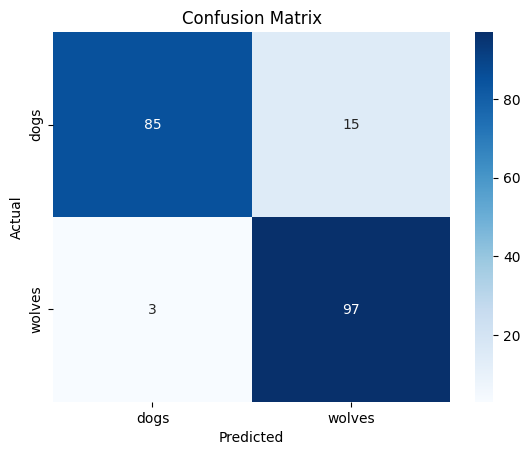

In [66]:
# 5. 실험 Case 1: 도메인 유사
print("\n===== Case 1: Dogs vs Wolves (도메인 유사) =====\n")
model_similar = build_vgg16_model(fine_tune=False)
model_similar, history_similar = train_model(model_similar, train_gen_similar, val_gen_similar, 'vgg16_dogs_vs_wolves.keras')
evaluate_model(model_similar, test_gen_similar)


--- Fine-Tuning Dogs vs Wolves ---

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.7999 - loss: 0.4509 - val_accuracy: 0.9250 - val_loss: 0.1847 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9295 - loss: 0.1825 - val_accuracy: 0.9100 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9407 - loss: 0.1550 - val_accuracy: 0.9250 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9658 - loss: 0.1004 - val_accuracy: 0.9475 - val_loss: 0.1305 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9412 - loss: 0.1567 - val_accuracy: 0.9250 - val_loss: 0.1765 - learning_rate: 1.0000e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9508 - loss: 0.1108 - val_accuracy: 0.9575 - val_loss: 0.1106 - learning_rate: 1.0000e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━

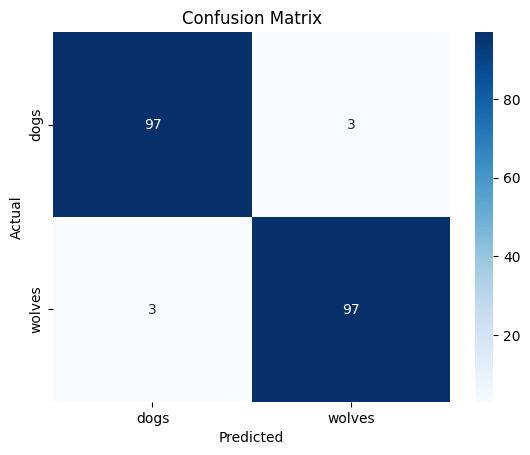

In [67]:
# Fine-Tuning 단계
print("\n--- Fine-Tuning Dogs vs Wolves ---\n")
model_similar_ft = build_vgg16_model(fine_tune=True)
model_similar_ft.set_weights(model_similar.get_weights())  # 가중치 이전
model_similar_ft, history_similar_ft = train_model(model_similar_ft, train_gen_similar, val_gen_similar, 'vgg16_dogs_vs_wolves_ft.keras')
evaluate_model(model_similar_ft, test_gen_similar)


===== Case 2: Fox Dataset (도메인 상이) =====

Epoch 1/30


c:\ProgramData\anaconda3\envs\dsgs\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2962 - loss: 0.8889 - val_accuracy: 0.9655 - val_loss: 0.5849 - learning_rate: 1.0000e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6283 - loss: 0.6335 - val_accuracy: 1.0000 - val_loss: 0.3432 - learning_rate: 1.0000e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9068 - loss: 0.3993 - val_accuracy: 1.0000 - val_loss: 0.2038 - learning_rate: 1.0000e-04
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9757 - loss: 0.2940 - val_accuracy: 1.0000 - val_loss: 0.1276 - learning_rate: 1.0000e-04
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9972 - loss: 0.1915 - val_accuracy: 1.0000 - val_loss: 0.0845 - learning_rate: 1.0000e-04
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 0.1424 - val_accuracy: 1.0000 - val_loss: 0.0593 - learning_rate: 1.0000e-04
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 0.1195 - val_accuracy: 1

C:\Users\K-PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


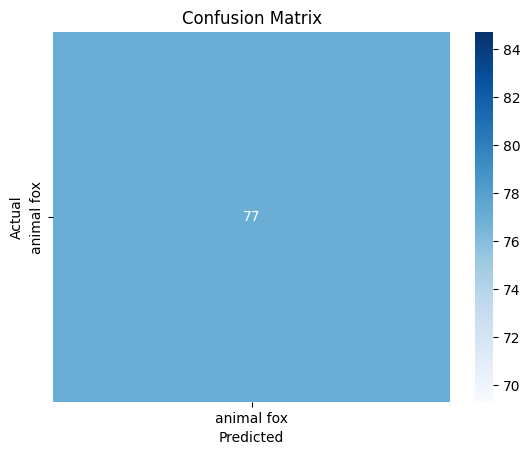

In [68]:
# 6. 실험 Case 2: 도메인 상이
print("\n===== Case 2: Fox Dataset (도메인 상이) =====\n")
model_dissimilar = build_vgg16_model(fine_tune=False)
model_dissimilar, history_dissimilar = train_model(model_dissimilar, train_gen_dissimilar, val_gen_dissimilar, 'vgg16_fox.keras')
evaluate_model(model_dissimilar, test_gen_dissimilar)


--- Fine-Tuning Fox Dataset ---

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.7012e-14 - learning_rate: 1.0000e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 1.7555e-09 - val_accuracy: 1.0000 - val_loss: 1.8135e-20 - learning_rate: 1.0000e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 4.3853e-12 - val_accuracy: 1.0000 - val_loss: 1.0988e-23 - learning_rate: 1.0000e-04
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 1.0336e-11 - val_accuracy: 1.0000 - val_loss: 2.5076e-25 - learning_rate: 1.0000e-04
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 2.6505e-14 - val_accuracy: 1.0000 - val_loss: 1.7358e-25 - learning_rate: 2.0000e-05
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 1.6492e-13 - val_accuracy: 1.0000 - val_loss: 1.4591e-25 - learning_rate: 2.0000e-05
Epoch 7/30

C:\Users\K-PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


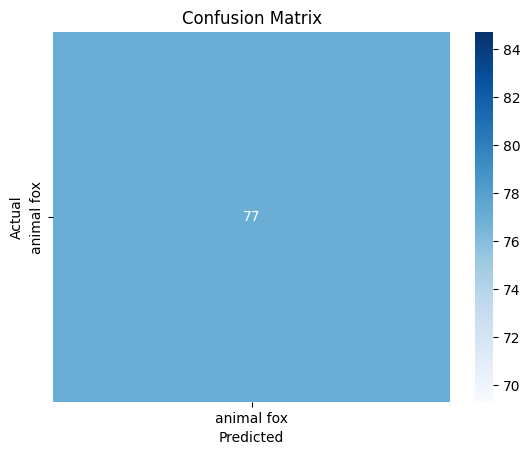

In [69]:
# Fine-Tuning 단계
print("\n--- Fine-Tuning Fox Dataset ---\n")
model_dissimilar_ft = build_vgg16_model(fine_tune=True)
model_dissimilar_ft.set_weights(model_dissimilar.get_weights())
model_dissimilar_ft, history_dissimilar_ft = train_model(model_dissimilar_ft, train_gen_dissimilar, val_gen_dissimilar, 'vgg16_fox_ft.keras')
evaluate_model(model_dissimilar_ft, test_gen_dissimilar)

In [82]:
def plot_learning_curve(history, title='Model Accuracy & Loss'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

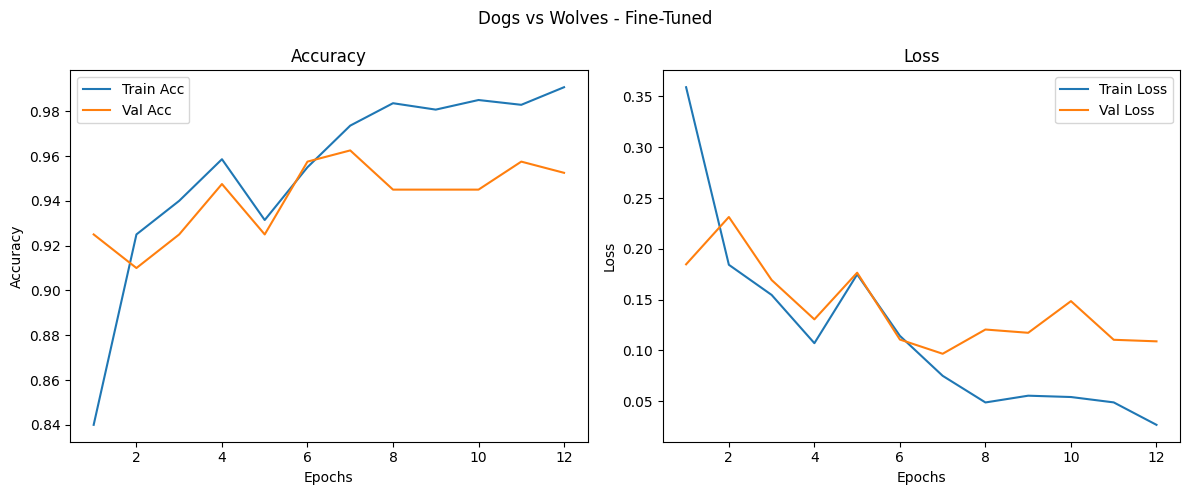

In [90]:
plot_learning_curve(history_similar_ft, title='Dogs vs Wolves - Fine-Tuned')

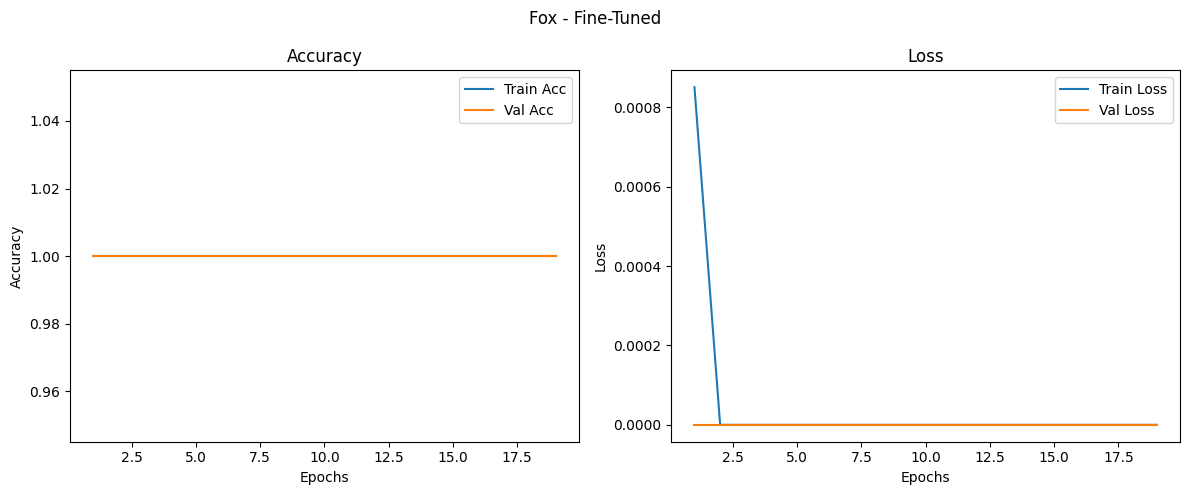

In [92]:
plot_learning_curve(history_dissimilar_ft, title='Fox - Fine-Tuned')

In [93]:
def compare_domain_performance(models, test_sets, labels):
    acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for model, test_data in zip(models, test_sets):
        y_true = test_data.classes
        y_pred = model.predict(test_data)
        y_pred_label = (y_pred > 0.5).astype(int)

        report = classification_report(y_true, y_pred_label, output_dict=True)
        acc_list.append(report['accuracy'])
        precision_list.append(report['0']['precision'])
        recall_list.append(report['0']['recall'])
        f1_list.append(report['0']['f1-score'])

    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    plt.bar(x - 1.5*width, acc_list, width, label='Accuracy')
    plt.bar(x - 0.5*width, precision_list, width, label='Precision')
    plt.bar(x + 0.5*width, recall_list, width, label='Recall')
    plt.bar(x + 1.5*width, f1_list, width, label='F1 Score')

    plt.xticks(x, labels)
    plt.title("Domain Generalization Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


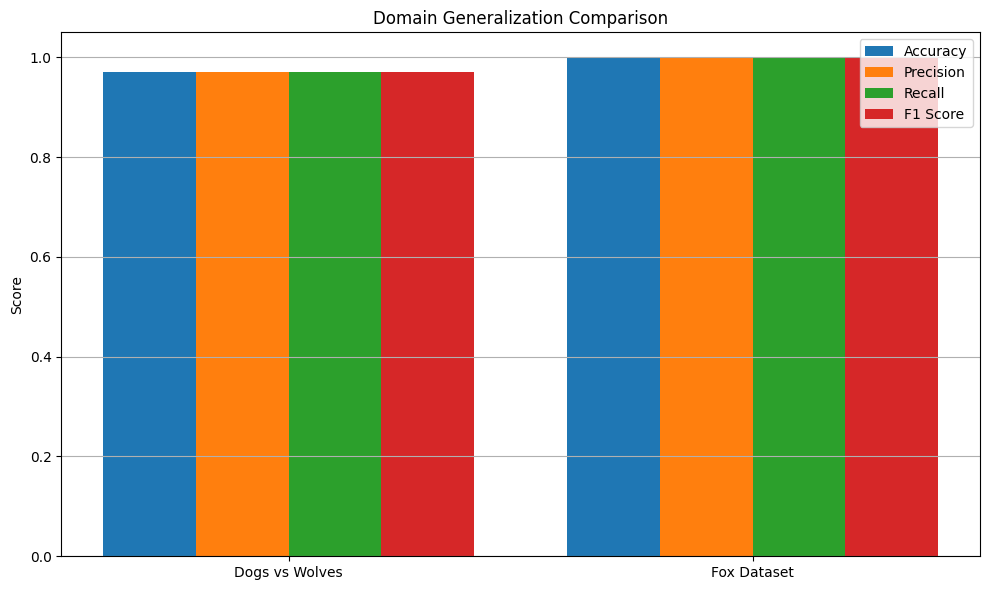

In [94]:
compare_domain_performance(
    [model_similar_ft, model_dissimilar_ft],
    [test_gen_similar, test_gen_dissimilar],
    ['Dogs vs Wolves', 'Fox Dataset']
)